# Brickset API Viewer

----
## Functionality
The Brickset API Viewer allows you to view aggregated information about Lego sets from a range of years that you specify. It calls the Rebrickable API documented [here](https://rebrickable.com/api/v3/docs/?key=). It will give you information about the average number of pieces in sets over time, as well as the largest and smallest sets from each year in the range.

----
## Usage
1. Enter valid start and end years in the cell just below. The script will tell you if you've entered a value that cannot be processed as a year.
2. Click **Cell** > **Run All** in the menu above. 
3. Allow the API viewer time to run. It will take longer to return information if you enter a wider range of years and if the years contain a large number of sets. 


In [27]:
# Enter the start and end year of the range of years you'd like to examine. 
start_year = 1985
end_year = 2015

      Average Pieces                                  Smallest Set  \
1985             112                                 Red Baseplate   
1986              98                          Battery Control Unit   
1987              66                                        Rattle   
1988             132                                9V Battery Box   
1989              95                              Change-Over Unit   
1990             172                                 Rabbit Rattle   
1991             132                          Large Building Plate   
1992             111                          Large Building Plate   
1993             130                               12V Motor (old)   
1994             113                              Pneumatic Tubing   
1995             145                  Battery Box with Switch - 9v   
1996             160                                   Plate 4 x 4   
1997             117  Cyber Saucer TRU 50 Years Forever Fun Bundle   
1998             137

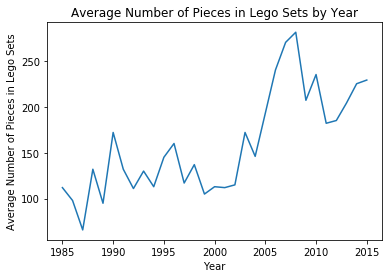

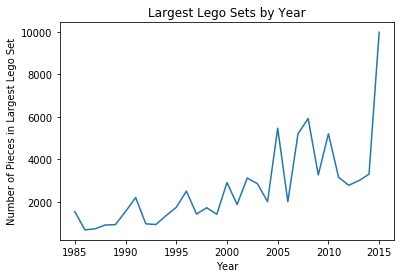

In [29]:
# -*- coding: utf-8 -*-
"""
@author: joel.whiteman
"""
import requests
import json
import statistics
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

def validate_year_values(start_year, end_year):
    """
    Validates that the user-inputted start_year and end_year values are valid integers.
    """
    if str(start_year).isdigit() and str(end_year).isdigit():
        return True
    
def year_iterator(start_year, end_year):
    """
    Calls the api and builds five dictionaries with information about the years scanned.
    
    Iterates over a year_list and calls an API URL to build a series of dictionaries containing information 
    about the years scanned. These dictionaries have the years as the key and the values are the average 
    number of pieces in a set from that year, the minimum number of pieces, the maximum number of pieces, 
    the name of the set with the minimum number of pieces, and the name of the set with the maximum number 
    of pieces. For each year in year_list, the function creates an api_url composed of an 
    api_key and the year. It then calls get_json_by_year on that api_url and checks if the returned
    json includes any sets and if the year is valid. If it does, it calls get_year_dict to get relevant
    information about that year. Finally it populates average_dict, min_pieces_dict, min_set_dict, 
    max_pieces_dict, and max_set_dict with the information from each year's year_dict.
    """
    average_dict = {}
    min_pieces_dict = {}
    min_set_dict = {}
    max_pieces_dict = {}
    max_set_dict = {}
    api_key = '15d39fe69a701f30c44cd700a1faa9a4'
    for year in range(start_year, (end_year + 1)):
        api_url =('https://rebrickable.com/api/v3/lego/sets/?key=' + api_key + '&min_year=' + 
            str(year) + '&max_year='  + str(year) + '&page_size=1000')
        year_json = get_json_by_year(api_url)
        if year_json:
            if year_json['count'] != 0:
                year_dict = get_year_dict(year_json)
                average_dict[year] = year_dict['average_parts']
                min_pieces_dict[year] = year_dict['min_set_pieces']
                min_set_dict[year] = year_dict['min_set_name']
                max_pieces_dict[year] = year_dict['max_set_pieces']
                max_set_dict[year] = year_dict['max_set_name']                                  
            # Fires if there were no sets listed for a given year
            else:
                average_dict[year] = 0
                min_pieces_dict[year] = "N/A"
                min_set_dict[year] = "N/A"
                max_pieces_dict[year] = "N/A"
                max_set_dict[year] = "N/A"                                     
        # Fires if the API returns a failure status for a given year 
        else:
            average_dict[year] = 0
            min_pieces_dict[year] = "N/A"
            min_set_dict[year] = "N/A"
            max_pieces_dict[year] = "N/A"
            max_set_dict[year] = "N/A" 
    return average_dict, min_pieces_dict, min_set_dict, max_pieces_dict, max_set_dict

def get_json_by_year(api_url):
    """
    Calls an api_url, checks if the status is valid, and reads the returned json into a dict.
    
    Uses a structured api_url to make an api call. If the call returns a valid 200 status code, 
    uses the json.loads module to build a dictionary of all of the data returned for that year. If 
    the call returns an invalid status code, returns 'None'.
    """
    api_request = requests.get(api_url)
    if api_request.status_code == 200:
        year_json = json.loads(api_request.text)
        return year_json
    else:
        return None

def get_year_dict(year_json):
    """
    Iterates over a year_json to extract information about that year's lego sets.
    
    Iterates over the list of lego set dictionaries stored in the year_json key 'results.' Since 
    each list item is its own lego_set dictionary with the data regarding that particular set, the 
    function looks at the 'num_parts' and 'name' fields in each set's dictionary. The function 
    checks for sets listed as containing zero pieces and ignores them. It then builds a num_parts_dict 
    containing the names of all the valid sets and the number of pieces they contain, using a set_counter
    variable to avoid duplicating names. It then calculates the average number of pieces in that year's 
    sets along with the minumum and maximum number of pieces and the names of the sets that had them.
    """
    set_counter = 0
    total_parts = 0
    num_parts_dict = {}
    for lego_set in year_json['results']:
        set_counter += 1
        if lego_set['num_parts'] != 0:            
            if lego_set['name'] not in num_parts_dict:
                num_parts_dict[(lego_set['name'])] = lego_set['num_parts']
            else:
                dict_name = lego_set['name'] + " " + str(set_counter)
                num_parts_dict[dict_name] = lego_set['num_parts']      
    float_average = statistics.mean(num_parts_dict.values())
    average_parts = round(float_average)
    year_dict = {
                "average_parts" : average_parts,
                "min_set_name" : min(num_parts_dict, key=num_parts_dict.get),
                "min_set_pieces" : min(num_parts_dict.values()),
                "max_set_pieces" : max(num_parts_dict.values()),
                "max_set_name" : max(num_parts_dict, key=num_parts_dict.get)
                }
    return year_dict

def create_summary_dict(average_dict, min_pieces_dict, min_set_dict, max_pieces_dict, max_set_dict):
    """
    Creates a summary dictionary with all the relevant information about a given year.
    
    Uses the aggregated dictionaries of all information extracted from the API jsons to build a summary_dict
    with years as keys and a list for values. The items in the list are the average number of pieces in a set 
    from that year, the name of the smallest set, the smallest number of pieces in a set, the name of the largest 
    set, and the largest number of pieces in a set.
    """
    summary_dict = {}
    for year in average_dict:
        summary_dict[year] = [
                                average_dict[year],
                                min_set_dict[year],
                                min_pieces_dict[year],
                                max_set_dict[year],
                                max_pieces_dict[year]
                             ]
    return summary_dict

def create_average_parts_visualization(average_dict):
    """
    Uses matplotplib to create a line graph of the average number of pieces in lego sets by year.
    """
    figure, axis = plt.subplots()
    axis.plot(list(average_dict.keys()), list(average_dict.values()))
    axis.set_xlabel('Year')
    axis.set_ylabel('Average Number of Pieces in Lego Sets')
    axis.set_title('Average Number of Pieces in Lego Sets by Year')

def create_max_parts_visualization(max_pieces_dict):
    """
    Uses matplotplib to create a line graph of the largest lego sets by year.
    """
    figure, axis = plt.subplots()
    axis.plot(list(max_pieces_dict.keys()), list(max_pieces_dict.values()))
    axis.set_xlabel('Year')
    axis.set_ylabel('Number of Pieces in Largest Lego Set')
    axis.set_title('Largest Lego Sets by Year')
    
def create_table(summary_dict):
    """
    Creates a Pandas dataframe with information about each year in the given range.
    """
    columns_list = [
                    "Average Pieces", 
                    "Smallest Set", 
                    "Smallest Set Size", 
                    "Biggest Set", 
                    "Biggest Set Size"
                    ]
    table = pd.DataFrame.from_dict(summary_dict, orient='index', columns = columns_list)
    return table

def main():
    years_valid = validate_year_values(start_year, end_year)
    if years_valid:
        #year_list = create_year_list(start_year, end_year)
        average_dict, min_pieces_dict, min_set_dict, max_pieces_dict, max_set_dict = year_iterator(start_year, end_year)
        summary_dict = (
            create_summary_dict(average_dict, min_pieces_dict, min_set_dict, max_pieces_dict, max_set_dict)
            )
        create_average_parts_visualization(average_dict)
        create_max_parts_visualization(max_pieces_dict)
        table = create_table(summary_dict)
        print(table)
    else: 
        print('One of your year values appears to be invalid!')

if __name__ == "__main__":
    main()